In [3]:
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

In [4]:
az.style.use('arviz-darkgrid')

## Non-Markovian methods

### Grid computing


In [5]:
def posterior_grid(grid_points=50, heads=6, tails=9):
    """ 
    A grid implementation for the coin-flipping problem 
    """
    grid = np.linspace(0, 1, grid_points)
    prior = np.repeat(1/grid_points, grid_points)  # uniform prior
    likelihood = stats.binom.pmf(heads, heads+tails, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return grid, posterior

Assuming we flip a coin 13 times and we observed 3 head we have:

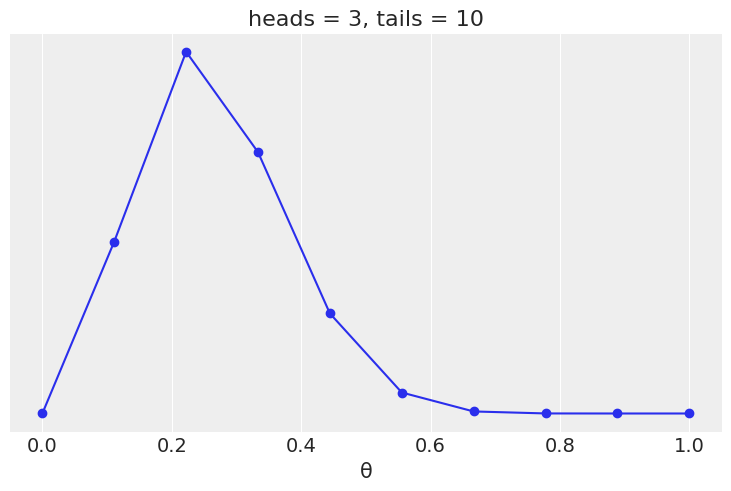

In [6]:
data = np.repeat([0, 1], (10, 3))
points = 10
h = data.sum()
t = len(data) - h
grid, posterior = posterior_grid(points, h, t) 

plt.plot(grid, posterior, 'o-')

plt.title(f'heads = {h}, tails = {t}')
plt.yticks([])
plt.xlabel('θ');
plt.savefig('B11197_08_01.png')

### Quadratic method

In [7]:
with pm.Model() as normal_aproximation:
    p = pm.Beta('p', 1., 1.)
    w = pm.Binomial('w',n=1, p=p, observed=data)
    mean_q = pm.find_MAP()
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]
mean_q['p'], std_q

(array(0.23076923), array([0.11685454]))

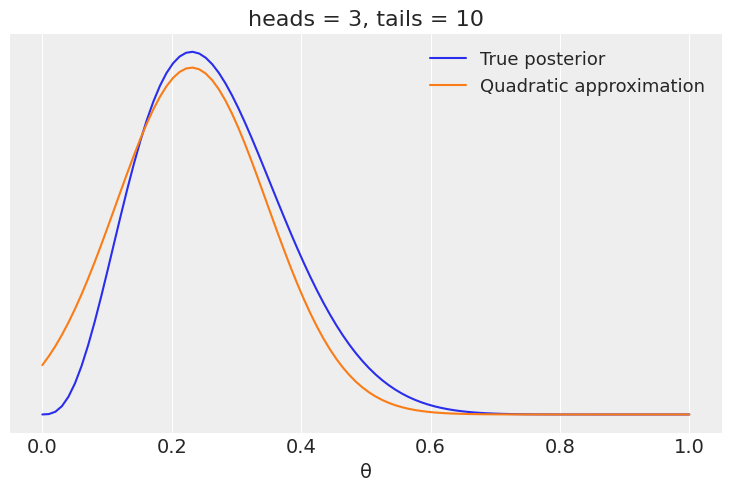

In [8]:
# analytical calculation
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x , h+1, t+1),
         label='True posterior')

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q['p'], std_q),label='Quadratic approximation')
plt.legend(loc=0, fontsize=13)

plt.title(f'heads = {h}, tails = {t}')
plt.xlabel('θ', fontsize=14)
plt.yticks([])
plt.savefig('B11197_08_03.png');

## Markovian methods

### Monte Carlo


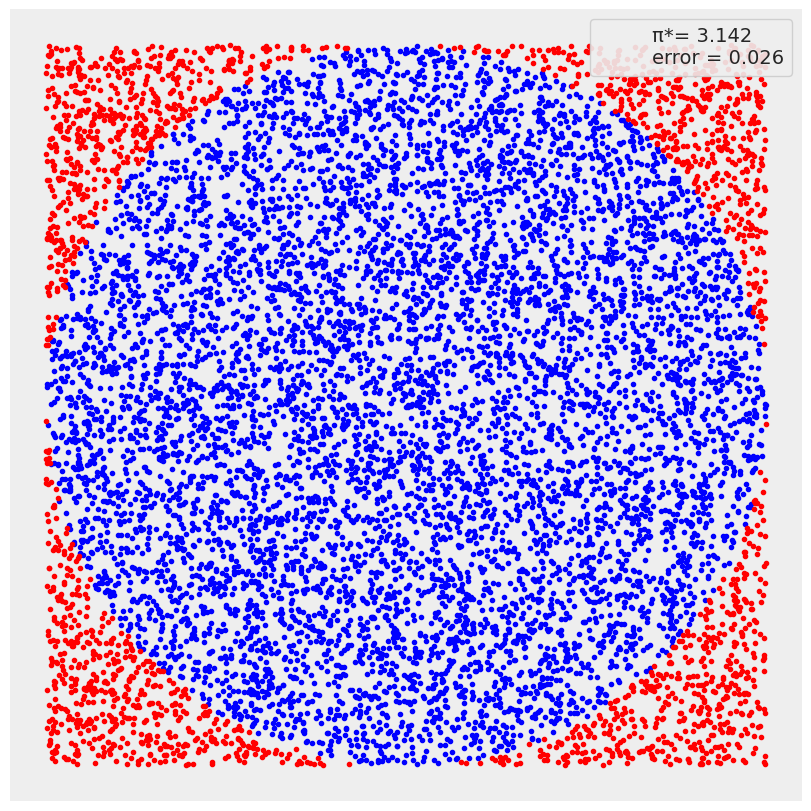

In [9]:
N = 10000

x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum()*4/N
error = abs((pi - np.pi) / pi) * 100
 
outside = np.invert(inside)
 
plt.figure(figsize=(8, 8))
plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0, 0, label=f'π*= {pi:4.3f}\nerror = {error:4.3f}', alpha=0)
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.legend(loc=1, frameon=True, framealpha=0.9)
plt.savefig('B11197_08_04.png');

In [10]:
def metropolis(func, draws=10000):
    """A very simple Metropolis implementation"""
    trace = np.zeros(draws)
    old_x = 0.5  # func.mean()
    old_prob = func.pdf(old_x)

    delta = np.random.normal(0, 0.5, draws)
    for i in range(draws):
        new_x = old_x + delta[i]
        new_prob = func.pdf(new_x)
        acceptance = new_prob / old_prob
        if acceptance >= np.random.random():
            trace[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            trace[i] = old_x

    return trace

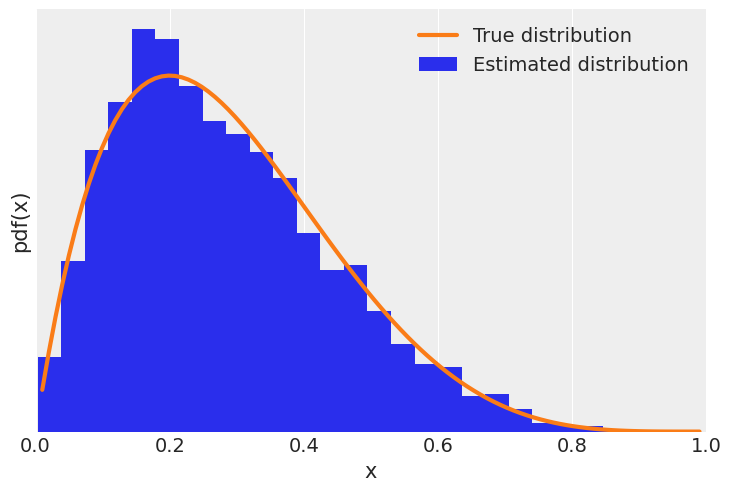

In [11]:
np.random.seed(3)
func = stats.beta(2, 5) 
trace = metropolis(func=func) 
x = np.linspace(0.01, .99, 100) 
y = func.pdf(x) 
plt.xlim(0, 1) 
plt.plot(x, y, 'C1-', lw=3, label='True distribution') 
plt.hist(trace[trace > 0], bins=25, density=True, label='Estimated distribution') 
plt.xlabel('x') 
plt.ylabel('pdf(x)')
plt.yticks([]) 
plt.legend()
plt.savefig('B11197_08_05.png');

## Diagnosing the samples

In [12]:
with pm.Model() as centered_model:
    a = pm.HalfNormal('a', 10)
    b = pm.Normal('b', 0, a, shape=10)
    idata_cm = pm.sample(2000, random_seed=124, target_accept=0.9, return_inferencedata=True)

with pm.Model() as non_centered_model:
    a = pm.HalfNormal('a', 10)

    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=10)
    b = pm.Deterministic('b', 0 + b_offset * a)
    idata_ncm = pm.sample(2000, random_seed=124, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8185618549613777, but should be close to 0.9. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.809350582686288, but should be close to 0.9. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8052740182194843, but should be close to 0.9. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
I

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.


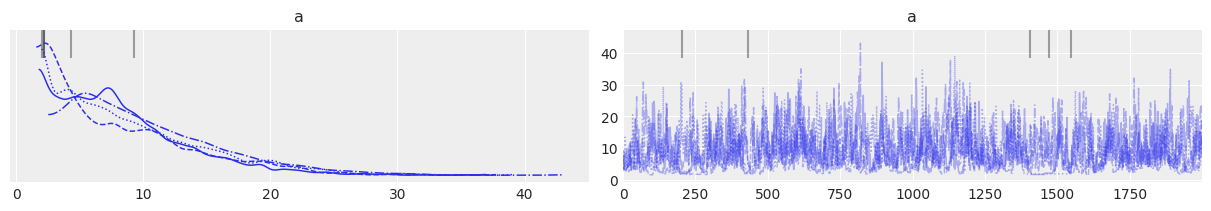

In [13]:
az.plot_trace(idata_cm, var_names=['a'], divergences='top')
plt.savefig('B11197_08_07.png');

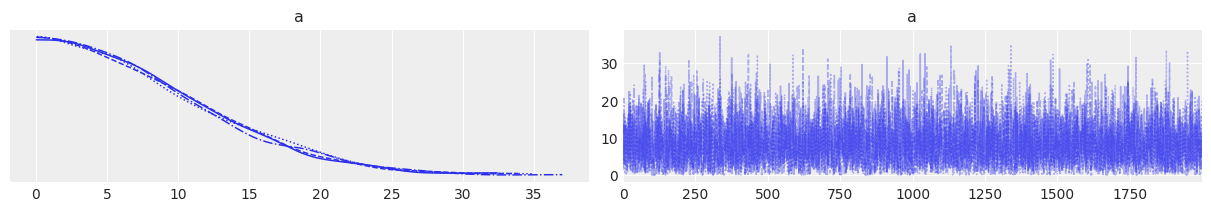

In [14]:
az.plot_trace(idata_ncm, var_names=['a'])
plt.savefig('B11197_08_08.png');

In [15]:
az.rhat(idata_cm)['a'].values

array(1.03128355)

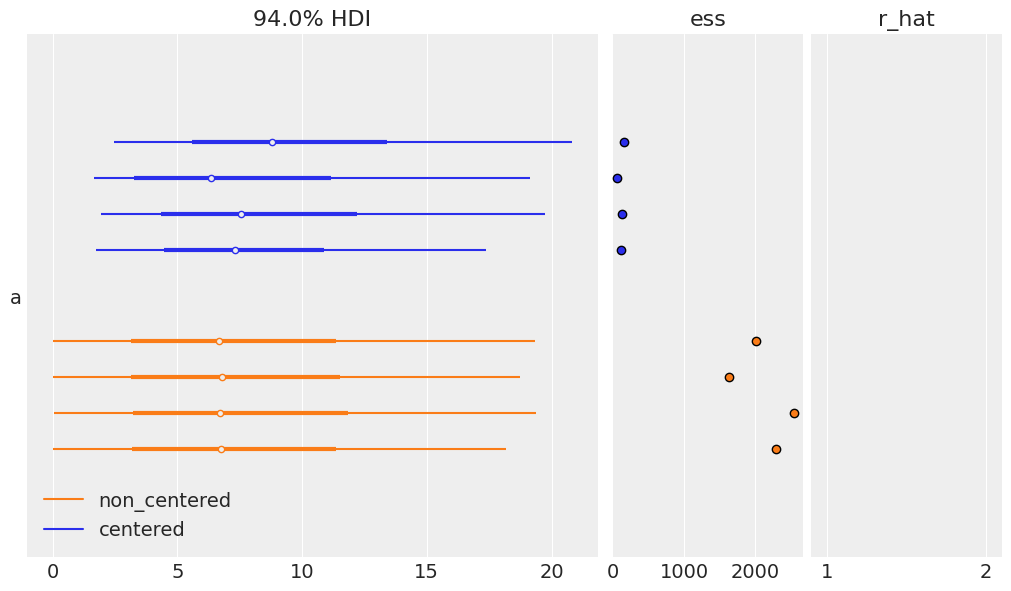

In [16]:
az.plot_forest([idata_cm, idata_ncm], model_names=['centered', 'non_centered'],
               var_names=['a'], r_hat=True, ess=True)
plt.savefig('B11197_08_10.png')

In [17]:
summaries = pd.concat([az.summary(idata_cm, var_names=['a']),
           az.summary(idata_ncm, var_names=['a'])])
summaries.index = ['centered', 'non_centered']
summaries

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
centered,8.842,5.673,1.757,19.462,0.306,0.217,166.0,105.0,1.03
non_centered,7.995,6.071,0.009,18.999,0.066,0.047,5550.0,3004.0,1.00


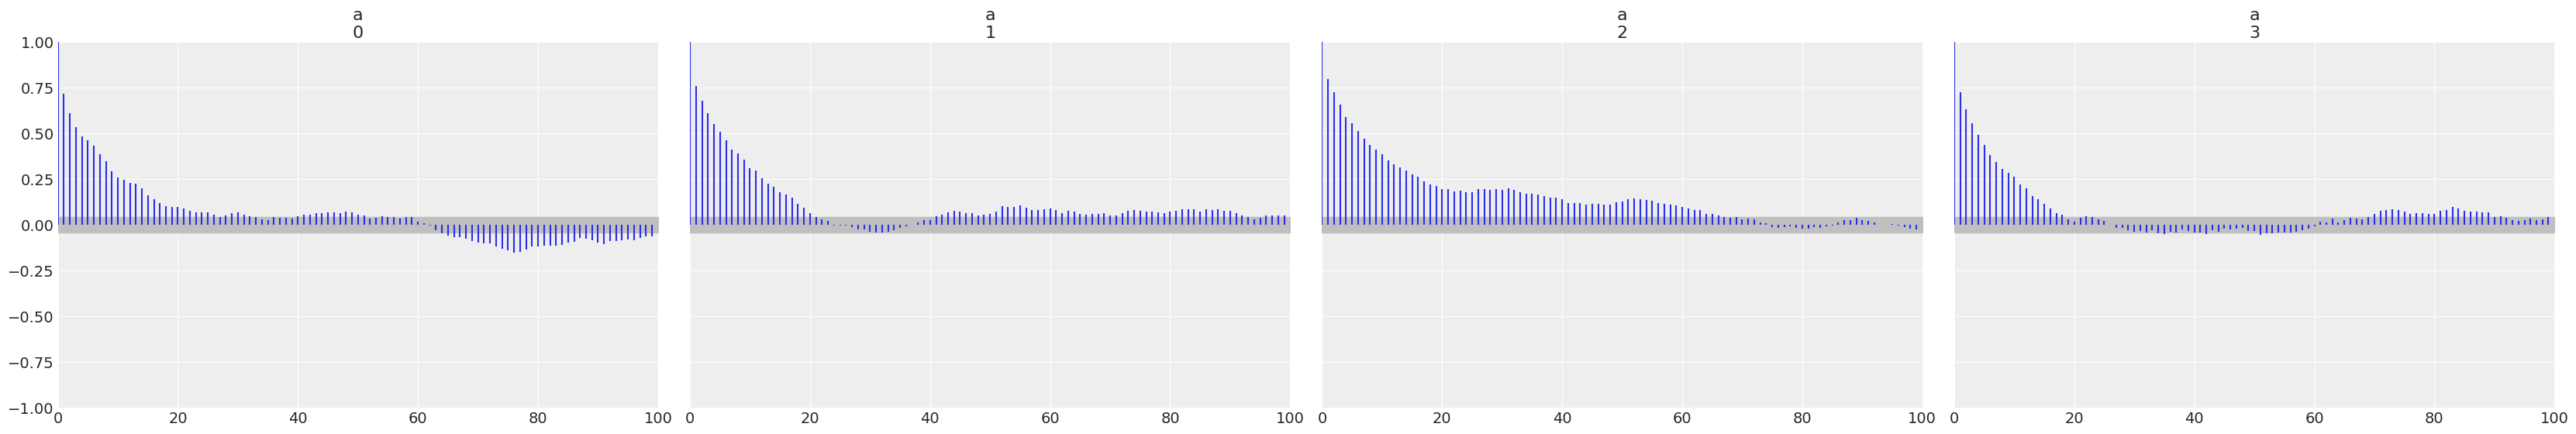

In [18]:
az.plot_autocorr(idata_cm, var_names=['a'])
plt.savefig('B11197_08_11.png');

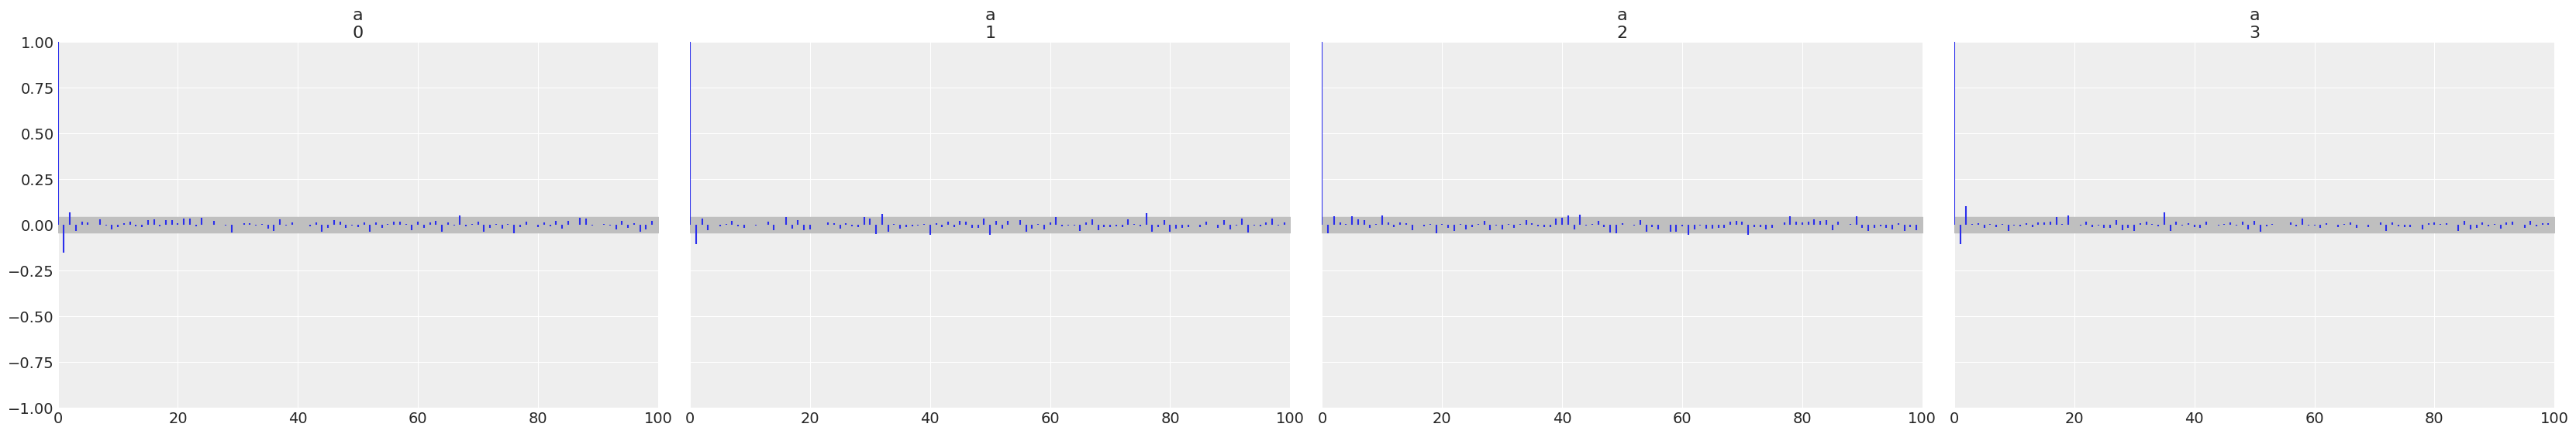

In [19]:
az.plot_autocorr(idata_ncm, var_names=['a'])
plt.savefig('B11197_08_12.png');

## Effective sample size

In [20]:
az.ess(idata_cm)['a'].values

array(165.74682768)

## Divergences

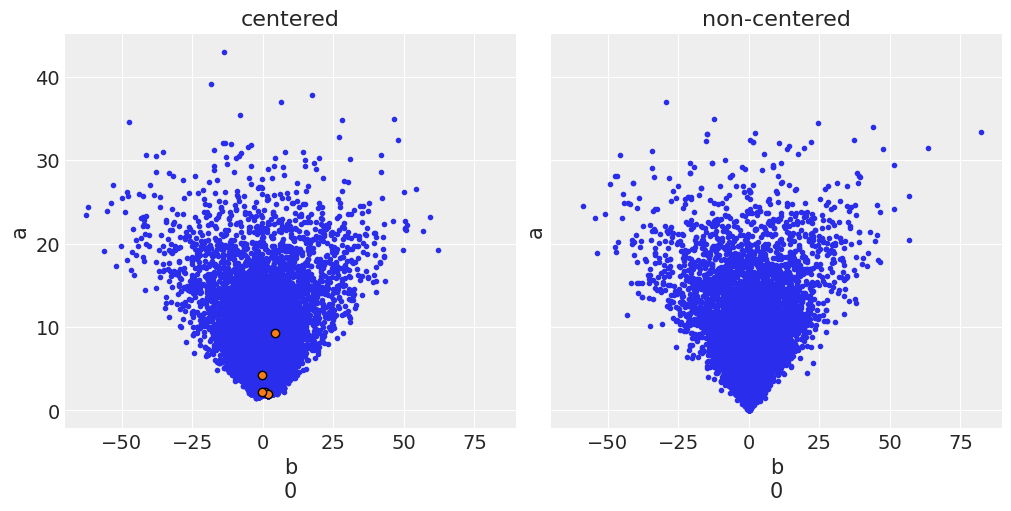

In [21]:
_, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5), constrained_layout=True)

for idx, tr in enumerate([idata_cm, idata_ncm]):
    az.plot_pair(tr, var_names=['b', 'a'], coords={'b_dim_0':[0]}, kind='scatter',
                 divergences=True, contour=False, divergences_kwargs={'color':'C1'},
                 ax=ax[idx])
    ax[idx].set_title(['centered', 'non-centered'][idx])
plt.savefig('B11197_08_13.png');

<ipython-input-31-379d87522f25>:2: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('B11197_08_14.png');
/u/32/martino5/unix/anaconda3/envs/pymcv3/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


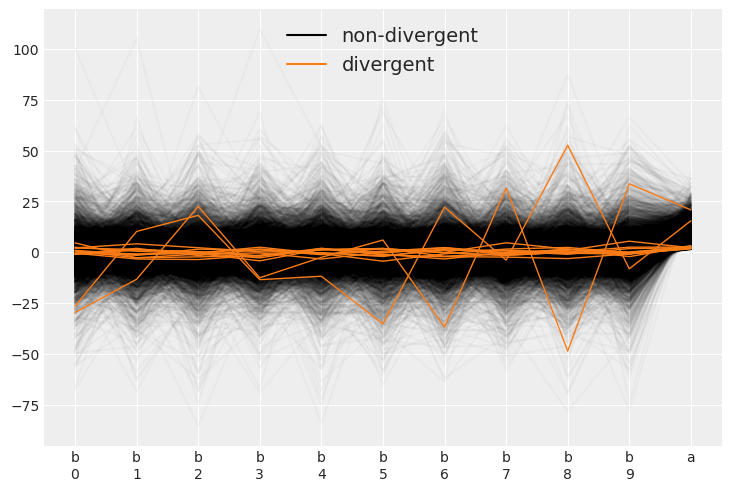

In [31]:
az.plot_parallel(idata_cm)
plt.savefig('B11197_08_14.png');